# ProDAtt and ExDAtt Model Intuition
By Warren Woodrich Pettine, July 2022

This notebook is designed to build intuition regarding key components of the ProDAtt and ExDAtt models. Consider this a tutorial on the model's fundamental mechanisms. It will move through those components one by one, introducing the algorithm along with code to work through. For an indepth explanation of the model, please see the methods section in the publication:

Pettine, W. W., Raman, D. V., Redish, A. D., & Murray, J. D. (2021, December 6). Human latent-state generalization through prototype learning with discriminative attention. https://doi.org/10.31234/osf.io/ku4fr

For the full code of the model, please see the implementation provided in the repository found at:

[LINK TO REPOSITORY]

The code for this notebook and the background functions is publically available at:

https://github.com/murraylab/ProDAttExDAttModelIntuition

In [1]:
from modelIntuitionFunctions import *

## Estimate Context
 First, we're going to look at how the model infers context. This is the step surrounded by the black dashed lines in the diagram below. 

![estimate_context_diagram](files/diagram_estimate_context.png)

The models estimate context through creating a set of the most likely states. That process is dictated by the algorithm:

![estimate_context_algorithm](files/algorithm_estimate_context.png)

We will walk through a simplified version, where you can specify the incoming cues, along with the states and the threshold for context inclusion. Consider the case in the diagram, where the model is trying to determine the type of cereal. Let's say the first two elements of the cue vector are associated with the color of the cereal (gold or brown), the second two with the size of the grains (small or medium), and the third with the serving dish (bowl or plate). Here's an example, breaking down the components of the vector. 

![cue_vector_description](files/cue_vector_description.png)

The models can actually handle noisy inputs, but we'll be enforcing integer values to keep things simple.  

In the background, we're converting the states you provide into prototypes, but you don't have to worry about that for now. In the code below, try changing the values for the cue vector, the states or the surprise threshold and see how that affects the context.

In [2]:
# Initial cue where the elements are associated with: [color,color,size,size,dish,dish]
cue = np.array([1, 0, 1, 0, 1, 0]).astype(int)

# Different types of cereals
states = np.array([
    [1, 0, 1, 0, 1, 0],
    [0, 1, 1, 0, 1, 0],
    [1, 0, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 0]
]).astype(int)

# What is the threshold for inclusion in the context? The higher the number, the more are included
context_surprise_threshold = 600

# Calculate the context
context_states, surprise = inferContext(cue, states, context_surprise_threshold)
print(f'The surprise value for each state is {surprise}')
print(f'The context is: \n{context_states}')


The surprise index for each state is [-40.52759314036705, 584.4724067700681, 584.472406801906, inf]
The context is: 
[[1 0 1 0 1 0]
 [0 1 1 0 1 0]
 [1 0 0 1 1 0]]


/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/ProDAttExDAttModelIntuition/modelIntuitionFunctions.py:14: RuntimeWarning: divide by zero encountered in remainder
  if not (state_examples % state_examples.astype(int) == 0).all():
/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/ProDAttExDAttModelIntuition/modelIntuitionFunctions.py:75: RuntimeWarning: divide by zero encountered in remainder
  if (not (cue % cue.astype(int) == 0).all()) or (not (mu % mu.astype(int) == 0).all()):
/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/ProDAttExDAttModelIntuition/modelIntuitionFunctions.py:182: RuntimeWarning: divide by zero encountered in log
  S = -1 * np.log(A)


## Feature Attention
Now that we have a set of states forming the context, we'll determine the features that are most useful in discriminating between the options. These features become the targets of attention. The step is outlined in black dotted lines

![compute_feature_attention_diagram](files/diagram_compute_feature_attention.png)

### Compute Feature Attention Weights (mutual information)

First, we determine the weights for the features that maximally differentiate between potential states. Our model implements this through the computation of mutual information, as described in the following algorithm. 

![compute_feature_attention_algorithm](files/algorithm_compute_feature_attention.png)

To make it tangible, we'll calculate the weights for the states included in the context. Play with them and see how it shapes the weights. For reference, here are the options:

[1, 0, 1, 0, 1, 0]

[0, 1, 1, 0, 1, 0]

[1, 0, 0, 1, 1, 0]

[0, 1, 0, 1, 1, 0]

Text(0.5, 1.0, 'Feature Attention (MI)')

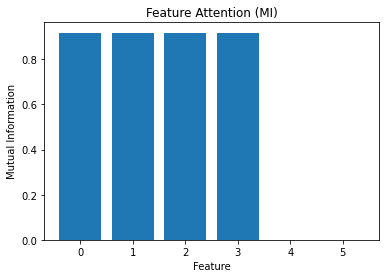

In [3]:
context_states = np.array([
    [1, 0, 1, 0, 1, 0],
    [0, 1, 1, 0, 1, 0],
    [1, 0, 0, 1, 1, 0]
])

#Calcualte the mutual information for each feature
MI = np.ones(context_states.shape[1])
for c in range(len(MI)):
    MI[c] = calcEntropy(context_states[:,c])

plt.bar(range(len(MI)), MI)
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.title('Feature Attention (MI)')


Next, we'll dive a bit deeper into how this is performed. To compute the feature attention weights, we used the mutual information between the cue and the states. Imagine the 4th feature is 1 for every example across every state (e.g. "bowl" being the container for cereal). So knowing that the 4th element doesn't reduce our uncertainty at all among the states that we know: if it's 1, it could be any type of cereal. However, the 1st feature (color) is 1 for wheat cereal (gold) and 0 for chocolate cereal (brown). Thus, knowing the 1st feature reduces our uncertainty regarding which state the example belongs to. This level of surprise reduction is mathematically the entropy, and it is used in the calculation of mutual information, as defined by the equations:

$I_{CS}(C_k,S) = H(C_k) - \sum_{i} H(C_{k}^{i})$

In this equation, $H(C_k)$ refers to the entropy of a cue (indexed by $k$) value across all states, and is calculated using

$H(C_k) = \sum_{t} p(c_k) log_{2}\big(p(c_k(t))\big)$.

The value $H(C_{k}^{i}$ refers to the entropy of a cue value for an individual state, and is calculated with:

$H(C_{k}^{i}) = p(s_{A,i}) \sum_{t \in s_{A,i}} p(c_k) log_{2}\big(p(c_k(t))\big)$. 

Nice in theory, but how does this play out for a functioning agent? Let's take the example of a single cue (0 or 1) that is defined across two states. We'll create a parameter "prop_mix," that defines the mixing of the cue between states. If prop_mix=0, state 0 is entirely cue 1 and state 1 is entirely cue 0. For prop_mix=0.5, the cues are evenly spread between the two states, etc. The feature attention weight will be minimal when the feature value is evenly distributed across the states (prop_mix=0.5), and maximized when it is entirely different for both states (prop_mix=0.0). Moreover, it is impacted by the number of states active, and the proportion of trials for which they have appeared. 

The code below shows the entropy of each variable and the mutual information at each mixture level. Modify it to examine what happens as you asymmetrically shift the distributions of cues across states. 

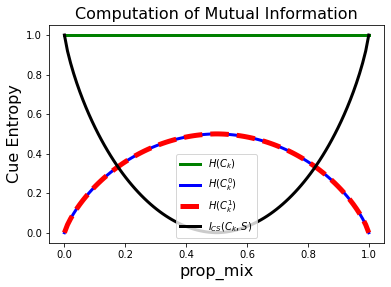

In [4]:
# Modify the relative proportion of trials that each state has appeared
prop_state_0 = 0.5
prop_state_1 = 0.5

# Make sure it normalizes to 1. We trust you to only provide float values!
if prop_state_0 + prop_state_1 != 1:
    sm = prop_state_0 + prop_state_1
    prop_state_0, prop_state_1 = prop_state_0/sm, prop_state_1/sm
    warnings.warn('The sum of the proportions of states is not 1. Values were re-normalized.')

#Create variables
n_trials_per_state = 100
prop_mix = np.linspace(0,1,100)
I, H_k, H_k_0, H_k_1 = prop_mix*0, prop_mix*0, prop_mix*0, prop_mix*0

#Calculate the entropy at each mixture
for p in range(len(prop_mix)):
    #Get stimuli
    stims_0 = np.zeros(n_trials_per_state)
    stims_0[:np.round(n_trials_per_state*prop_mix[p]).astype(int)] = 1
    stims_1 = np.ones(n_trials_per_state)
    stims_1[:np.round(n_trials_per_state*prop_mix[p]).astype(int)] = 0
    stims = np.concatenate((stims_0,stims_1))
    #Calc entropy
    H_k[p] = calcEntropy(stims)
    H_k_0[p] = prop_state_0 * calcEntropy(stims_0)
    H_k_1[p] = prop_state_1 * calcEntropy(stims_1)
#Get mutual Information
I = H_k - (H_k_0 + H_k_1)

#Plot the data
plt.plot(prop_mix,H_k,label='$H(C_k)$',linewidth=3,color='g')
plt.plot(prop_mix,H_k_0,label='$H(C_{k}^{0})$',linewidth=3,color='b')
plt.plot(prop_mix,H_k_1,label='$H(C_{k}^{1})$',linestyle='--',color='r',linewidth=5)
plt.plot(prop_mix,I,label='$I_{CS}(C_k,S)$',linewidth=3,color='k')
plt.xlabel('prop_mix',fontsize=16)
plt.ylabel('Cue Entropy',fontsize=16)
plt.title('Computation of Mutual Information',fontsize=16)
plt.legend()
plt.show()

### Modulate Feature Attention
A key feature of the model is that it modulates the weights based on the reward history, $\bar{\delta}$. The premise is that if the agent experiences a negative deviation from expected reward, it should increase attention to all features in the environment (i.e., reduce the use of mutual information). However, if the agent is experiencing the expected reward statistics, using attention reduces sensitivity to distracting information. 

To investigate the impact of this mechanisms, we implimented a parameter that linearly distorts the use of feature attention $\xi_{distortion}$. Thus, the attention weights ($w_A$) can be described as the function: 

$w_{A} = f(MI,\bar{\delta},\xi_{distortion})$

To gain some intution for MI, $\bar{\delta}$ and $\xi_{distortion}$, play with their values in the code below and see how that impacts the attention weights. 

Text(0.5, 1.0, 'Modulated Feature Attention')

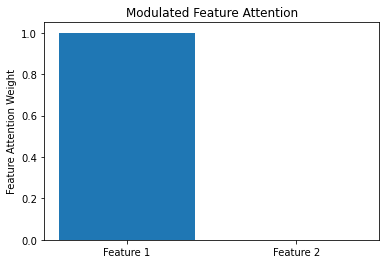

In [5]:
#Just an example MI for the manipulation
MI = np.array([1,0])

# The model tracks the integrated negative reward prediction error. 
# The dynamic range is -5 to -10. 
delta_bar = 0

# This parameter ranges from 0 to 1, where 0 means no distortion and 1 means full distortion.
attention_distortion = 0

w_A = modulateFeatureAttention(MI,delta_bar=delta_bar,attention_distortion=attention_distortion)

plt.bar(['Feature 1','Feature 2'],w_A)
plt.ylabel('Feature Attention Weight')
plt.title('Modulated Feature Attention')


## Estimate State

![compute_feature_attention](files/diagram_estimate_state.png)

The models estimate the current state, and are able to learn new states. To do this, the model determines how surprised it would be that the cue its encountering is generated by an underlying latent state. The use of surprise was mentioned earlier during the context inference section, but here we go just a bit more in depth. The models calculate suprise using a multivariate gaussian equation of the form, 

$P(s_{i} | c(t))P(c(t)) = \frac{1}{\sqrt{s\pi^{n_c} |{I_{WS,i}}^{-1}|}} exp\bigg( -\frac{1}{2} D^2_i(c(t)) \bigg)$.

To unpack the left side of the equation, it gives the likelihood of a state given a set of cues. Let's start by playing with those cues and covariance. In the model, we measure the radial of the cues from the expected values using the equations,

$Z_i(c(t)) = w_{A} ( c(t) - \mu_{i})$

and

$D^2_i(c(t)) = Z_i(c(t))' I_{WS,i} Z_i(c(t))$.

Let's say the agent is on a single trial, determining the suprise level for state 0. In the cell below, play with $c(t)$ and $mu_0$, then see how that changes the downstream variables. We'll also add an indicator for the creation of a new state. 

In [6]:
#Values to play with
c_t = np.array([1, 0]) #This is the stimulus seen on a specific trial. 
mu_0 = np.array([1, 0]) #This is the expected cue for the state

#Values to keep consistent
w_A = np.array([1, 1]) #This is the cue-weighting array.
I_precision = np.eye(2)*25  #The precision weights for a State 0.
surprise_threshold = 15  #The surprise threshold for a State 0.

#Calculate the output
Z = calcZ(w_A,c_t,mu_0)
print('Distance vector Z is ' + str(Z))
D2 = calcD2(Z,I_precision)[0][0]
print('Radial distance D2 is ' + str(D2))
A = calcActivation(I_precision,D2)
print('Activation is ' + str(A))
S = calcSurprise(A)
print('Surprise is ' + str(S))

if S > surprise_threshold:
    print('\nSurprise is above threshold. New State created!')

Distance vector Z is [0. 0.]
Radial distance D2 is 0.0
Activation is 9.973557010035815
Surprise is -2.299937291663528


This is a fairly simple engine for estimating the probability of a cue given a state. While we adopt it for conceptual simplicity,  The radial basis function as is results in stimulus matching. This is because the mechanism does not take into account perceptual noise, internal noise, nonlinear feature representation feature embending, decision uncertainty or other factors that can bring stimuli and internal states closer in perceptual space. To account for these in the most parsimonious way possible, we introduce a simple linear function that reduces the distance between the cues and internal states. The value is consistent throughout a session for all states. It is dictated by the parameter $\xi_{bl}$, and described in the equation,

$Z((ct)) = w_{A}(1 - \xi_{bl})(c(t) - \mu_{i}),$

where $\xi_{bl}$ controls the degree of bluring. 

We've added the parameter "blur_states_param_linear" ($\xi_{bl}$) in the cell below. As you increase it, the surprise will decrease. 

In [7]:
#Values to play with
blur_states_param_linear=0.5 #Reduces the distance between cue and internal states. Must range from 0 to 1. 
c_t = np.array([1, 0]) #This is the stimulus seen on a specific trial. 
mu_0 = np.array([0, 0]) #This is the expected cue for the state

#Values to keep consistent
w_A = np.array([1, 1]) #This is the cue-weighting array.
I_precision = np.eye(2)*25  #The precision weights for a State 0.
surprise_threshold = 15  #The surprise threshold for a State 0.

#Calculate the output
Z = calcZ(w_A,c_t,mu_0,blur_states_param_linear=blur_states_param_linear)
print('Distance vector Z is ' + str(Z))
D2 = calcD2(Z,I_precision)[0][0]
print('Radial distance D2 is ' + str(D2))
A = calcActivation(I_precision,D2)
print('Activation is ' + str(A))
S = calcSurprise(A)
print('Surprise is ' + str(S))

if S > surprise_threshold:
    print('\nSurprise is above threshold. New State created!')



Distance vector Z is [0.5 0. ]
Radial distance D2 is 6.25
Activation is 0.4382075123392134
Surprise is 0.8250627083364721


### Estimate Prototype State

Now, we will get into the specifics for the prototype version of the model (the ProDAtt). That model is described in the algorithm, 

![compute_feature_attention](files/algorithm_estimate_prototype_state.png)

For each state, the model defines a prototype mean and a covariance matrix of past prototype cues. The inverse of the covariance matrix is the precision, which provides a good estimate of the weight. 

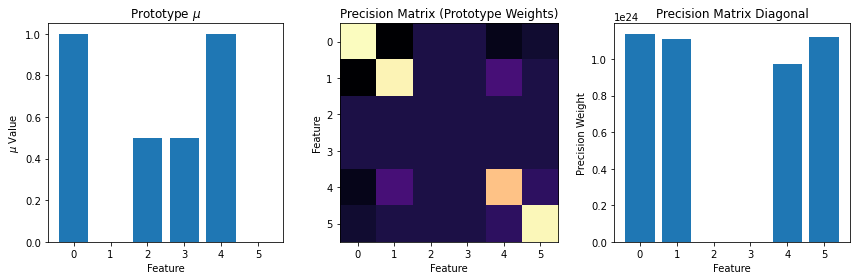

In [8]:
# Tweek this parameter, keeping it between 0 and 1
prop_exemplar_1 = 0.5

# Do some value checking
if (type(prop_exemplar_1) != float) and type(prop_exemplar_1) != int:
    raise ValueError('prop_exemplar_1 must be a float or int')
if prop_exemplar_1 < 0 or prop_exemplar_1 > 1:
    raise ValueError('prop_exemplar_1 must be between 0 and 1')

# Two types of chocolate cereal (don't change this)
state = np.array([
    [1, 0, 1, 0, 1, 0], # Chocolate cereal with large bits (exemplar 1). 
    [1, 0, 0, 1, 1, 0], # Chocolate cereal with small bits (exemplar 2). 
])

# Make the bank of state exemplars (don't change this)
n_examples = 100
state_examples = np.zeros((n_examples,state.shape[1]))
state_examples[:np.round(n_examples*prop_exemplar_1).astype(int),:] = state[0,:]
state_examples[np.round(n_examples*prop_exemplar_1).astype(int):,:] = state[1,:]

# Compute the prototype mean, covariance and precision (don't change this)
state_prototype_mu = np.mean(state_examples,axis=0)
state_prototype_cov = np.cov(state_examples+np.random.randn(state_examples.shape[0],state_examples.shape[1])*10**-12,rowvar=False)
state_prototype_precision = np.linalg.inv(state_prototype_cov)

# Plot the results
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].bar(range(len(state_prototype_mu)),state_prototype_mu)
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('$\\mu$ Value')
ax[0].set_title('Prototype $\\mu$')
ax[1].imshow(state_prototype_precision,cmap='magma')
ax[1].set_xlabel('Feature')
ax[1].set_ylabel('Feature')
ax[1].set_title('Precision Matrix (Prototype Weights)')
ax[2].bar(range(len(state_prototype_precision)),state_prototype_precision.diagonal())
ax[2].set_xlabel('Feature')
ax[2].set_ylabel('Precision Weight')
ax[2].set_title('Precision Matrix Diagonal')
plt.tight_layout()



    
Now, let's say the model encounters the following novel stimulus:

cue = [1, 0, 1, 0, 1, 0, 1]

The context it creates includes chocolate cereal, muesli cereal and chocolate crackers. However, given the last element in the cue vector, this novel cue doesn't perfectly match any of them. 

In the code below, examine how the surprise changes as you modify the proportions and switch out the cue. Also, try turning on and off feature attention to get a feel for how it changes the calculation

initial cue = [1, 0, 1, 0, 1, 0]



In [9]:
## Variabels to play with 
USE_FEATURE_ATTENTION = False
state_creation_threshold = 100
state_1_exemplar_props = np.array([.5,.5]) # The proportional representation of each exemplar for state 1
state_2_exemplar_props = np.array([1,0]) # The proportional representation of each exemplar for state 2
state_3_exemplar_props = np.array([1,0]) # The proportional representation of each exemplar for state 2

# The novel encounter
cue = np.array([1, 0, 1, 0, 1, 0, 1]).astype(int) # Initial cue

## Make the cereal types
# Chocolate cereal
state_1_exemplars = np.array([
    [1, 0, 1, 0, 1, 0, 0], # Chocolate cereal with large bits (exemplar 1). 
    [1, 0, 0, 1, 1, 0, 0], # Chocolate cereal with small bits (exemplar 2). 
]).astype(int)
# Muesli cereal
state_2_exemplars = np.array([
    [0, 1, 1, 0, 1, 0, 0], # Muesli cereal with large bits (exemplar 1). 
    [0, 1, 0, 1, 1, 0, 0], # Muesli cereal with small bits (exemplar 2). 
]).astype(int)
# Chocolate crackers
state_3_exemplars = np.array([
    [1, 0, 1, 0, 0, 1, 0], # Chocolate crackers with large bits (exemplar 1). 
    [1, 0, 0, 1, 0, 1, 0], # Chocolate crackers with small bits (exemplar 2). 
]).astype(int)

# Create the state examples. This time, we've cleaned it up in a function for you. 
state_1 = createPrototypeState(state_1_exemplars,exemplar_props=state_1_exemplar_props,noise_sigma=10**-8,n_examples=70)
state_2 = createPrototypeState(state_2_exemplars,exemplar_props=state_2_exemplar_props,noise_sigma=10**-6,n_examples=70)
state_3 = createPrototypeState(state_3_exemplars,exemplar_props=state_3_exemplar_props,noise_sigma=10**-6,n_examples=70)

# Get the feature attention (look back a few steps to refresh on these steps)
delta_bar = 0 # Integrated negative RPE
attention_distortion = 0 #Distortion of feature attention
if USE_FEATURE_ATTENTION:
    MI = calcMI([state_1['examples'],state_2['examples'],state_3['examples']])
else:
    MI = cue*0+.5
w_A = modulateFeatureAttention(MI,delta_bar=delta_bar,attention_distortion=attention_distortion)

# Calculate the surprise for each state
blur_states_param_linear = 0.95
state_1_surprise = calcStateSurprise(cue,state_1['mu'], state_1['precision'], w_A,blur_states_param_linear=blur_states_param_linear)
state_2_surprise = calcStateSurprise(cue,state_2['mu'], state_2['precision'], w_A,blur_states_param_linear=blur_states_param_linear)
state_3_surprise = calcStateSurprise(cue,state_3['mu'], state_3['precision'], w_A,blur_states_param_linear=blur_states_param_linear)


print(f'Surprise for state 1 = {state_1_surprise}')
print(f'Surprise for state 2 = {state_2_surprise}')
print(f'Surprise for state 3 = {state_3_surprise}')


if all([state_1_surprise>state_creation_threshold,state_2_surprise>state_creation_threshold,state_3_surprise>\
    state_creation_threshold]):
    print('\nAll states are above the threshold. Creating a new state.')


Surprise for state 1 = 288.32836195377587
Surprise for state 2 = 610.0625161940756
Surprise for state 3 = 610.0624991661219

All states are above the threshold. Creating a new state.


/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/ProDAttExDAttModelIntuition/modelIntuitionFunctions.py:14: RuntimeWarning: divide by zero encountered in remainder
  if not (state_examples % state_examples.astype(int) == 0).all():
/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/ProDAttExDAttModelIntuition/modelIntuitionFunctions.py:75: RuntimeWarning: divide by zero encountered in remainder
  if (not (cue % cue.astype(int) == 0).all()) or (not (mu % mu.astype(int) == 0).all()):


If more than one state is below the surprise threshold, the model then estimates a state using a softmax function over the likelihood values.

$P\big(\textnormal{select state } s(t)| P(c(t) | s_{i})\big) = exp(\beta_{S} P(c(t) | s_{i})/\sum_{i}
exp(\beta_{state} P(c(t) | s_{i})$


### Estimate Exemplar State

There is considerable debate in category learning as to whether, or in what task settings, humans compare new observations to prototypes, or to individual category exemplars. Under a prototype model, the distance to a new observation is calculated relative to a single state prototype for each state. Under an exemplar model, the distance of a new observation is calculated for every prior state example. The observation's distance from the state is a combination of individual distances.

To investigate exemplar state learning, we developed the ExDAtt model. The ExDAtt model is similar to the ProDAtt but for two essetial differences:
- It doesn't use the covariance among all exemplars.
- It calculates the surprise for each state exemplar, and then determines the state surprise through a weighted average of that for each exemplar. 

This is demonstrated in the following algorithm,

![estimate_exemplar_state](files/algorithm_estimate_exemplar_state.png)

To get the basic idea, work with computing the surprise of a single state. Play with the proportion of exemplar 1 and 2. See how that affects the ultimate surprise value. 

In [2]:
# Play with this value
exemplar_props=np.array([0.5,0.5])


# The novel encounter
cue = np.array([1, 0, 1, 0, 1, 0]).astype(int) # Initial cue

state_exemplars = np.array([
    [1, 0, 1, 0, 1, 0], # Chocolate cereal with large bits (exemplar 1). 
    [1, 0, 0, 1, 1, 0], # Chocolate cereal with small bits (exemplar 2). 
]).astype(int)

state = createExemplarState(state_exemplars,exemplar_props=exemplar_props)

exemplar_surprises = []
for s in range(len(state)):
    surprise = calcStateSurprise(cue,state[s]['mu'], state[s]['precision'],blur_states_param_linear=0.95)
    print(f'Surprise for state {s} = {surprise}')
    exemplar_surprises.append(surprise*exemplar_props[s])

print(f'State surprise = {np.sum(exemplar_surprises)}')

Surprise for state 0 = -38.44815159886477
Surprise for state 1 = 274.05184838556164
State surprise = 117.80184839334844


/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/ProDAttExDAttModelIntuition/modelIntuitionFunctions.py:53: RuntimeWarning: divide by zero encountered in remainder
  if not (state_exemplars % state_exemplars.astype(int) == 0).all():
/Users/wpettine/Dropbox/_Murray/Project/state_creation_RL/Paper/code/repos/ProDAttExDAttModelIntuition/modelIntuitionFunctions.py:76: RuntimeWarning: divide by zero encountered in remainder
  if (not (cue % cue.astype(int) == 0).all()) or (not (mu % mu.astype(int) == 0).all()):


## Select Action

Each state learns a set of action values. The selection of an action therefore is a simple softmax function over those values. 

![select_action](files/algorithm_select_action.png)

In [3]:
action_values = np.array([0.1,.5,.7])
beta = 2

action_probabilities = softmax(action_values, beta=beta)

action = np.random.choice(np.arange(0, len(action_probabilities)),
                                      p=action_probabilities)

print(f'Action probabilities are {action_probabilities}')
print(f'Action {action+1} was chosen.')

Action probabilities are [0.15277303 0.34000264 0.50722433]
Action 2 was chosen.


## Update State

On every trial, the selected action is updated using the Rescola-Wagner equation. If the agent received a reward on the trial, then it updates the state with a new example. The process is described in the algorithm,

![compute_feature_attention](files/algorithm_update_state.png)

We have left a few comments below for you to complete using the described algorithm. 

In [5]:
reward = True
action_value = 0.7
learning_rate = 0.1 # eta value

#Create the state
state = createPrototypeState(np.array([[1, 0, 1, 0, 1, 0], [1, 0, 0, 1, 1, 0]]))

# Implement an RW update on the action value


## IF REWARD IS RECEIVED
# update the state with a new example

# Update mu

# Recalculate precision (we provided an equation to help)
calcPrecision(state['examples'])

## Induce State Estimation Error
Most human subjects seemed to be commiting errors biased towards similar states,, while some human subjects produced errors that were. To gain insight into the pattern of errors produced by state estimation, we introduced a mechanism whereby it:
- Probabilistically made an error in state selection, and
- Could vary between randomly selecting another state to selecting the one most perceptually similar. 

The process is outlined in the algorithm, 

![compute_feature_attention](files/algorithm_induce_state_estimation_error.png)

At its core, the mechanism utilizes a common representational similarity metric. The euclidean distance between states is computed, and then a softmax function turns those distances into selection probabilities. 

To gain insight, start by seeing how the state representations are converted into distances. 

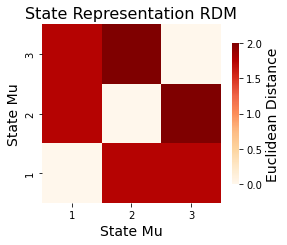

In [6]:
state_1_exemplar_props = np.array([.5,.5]) # The proportional representation of each exemplar for state 1
state_2_exemplar_props = np.array([1,0]) # The proportional representation of each exemplar for state 2
state_3_exemplar_props = np.array([1,0]) # The proportional representation of each exemplar for state 2

# The novel encounter
cue = np.array([1, 0, 1, 0, 1, 0, 1]).astype(int) # Initial cue

## Make the cereal types
# Chocolate cereal
state_1_exemplars = np.array([
    [1, 0, 1, 0, 1, 0, 0], # Chocolate cereal with large bits (exemplar 1). 
    [1, 0, 0, 1, 1, 0, 0], # Chocolate cereal with small bits (exemplar 2). 
]).astype(int)
# Muesli cereal
state_2_exemplars = np.array([
    [0, 1, 1, 0, 1, 0, 0], # Muesli cereal with large bits (exemplar 1). 
    [0, 1, 0, 1, 1, 0, 0], # Muesli cereal with small bits (exemplar 2). 
]).astype(int)
# Chocolate crackers
state_3_exemplars = np.array([
    [1, 0, 1, 0, 0, 1, 0], # Chocolate crackers with large bits (exemplar 1). 
    [1, 0, 0, 1, 0, 1, 0], # Chocolate crackers with small bits (exemplar 2). 
]).astype(int)

# Create the state examples. This time, we've cleaned it up in a function for you. 
state_1 = createPrototypeState(state_1_exemplars,exemplar_props=state_1_exemplar_props,noise_sigma=10**-8,n_examples=70)
state_2 = createPrototypeState(state_2_exemplars,exemplar_props=state_2_exemplar_props,noise_sigma=10**-6,n_examples=70)
state_3 = createPrototypeState(state_3_exemplars,exemplar_props=state_3_exemplar_props,noise_sigma=10**-6,n_examples=70)

# Calculate the representational disimilarity matrix
representation = np.array([state_1['mu'],state_2['mu'],state_3['mu']])
rdm = representationToRDM(representation)

# plot it
plotRDM(rdm)
plt.show()


Now, use those distance values to determine the state that gets substituted. The lower the beta parameter, the more random the agent ends up being in its errors. The higher beta, the more an agent's errors are biased for the similar state.  

In [7]:
# Manipulate these variables
state_initially_estimated = 1 # provide an index for the estimated state. If you're using the examples, its 1, 2 or 3
beta_state_estimation = 10 # Random estimation (low beta) to going for the closest state (high beta). 


# Get the selection probabilities
if type(state_initially_estimated) != int:
    raise ValueError('state_initially_estimated must be an integer')
distances = rdm[state_initially_estimated,:].copy()
distances[state_initially_estimated] = np.nan
selection_probabilities = softmax(distances, beta=beta_state_estimation)
selection_probabilities[np.isnan(selection_probabilities)] = 0

# Determine the state that will be selected
final_state_estimated = np.random.choice(np.arange(0, len(selection_probabilities)),
                                      p=selection_probabilities)

print(f'The state selection probabilities are {selection_probabilities}')
print(f'The estimated state is {final_state_estimated}')


The state selection probabilities are [0.06419439 0.         0.93580561]
The estimated state is 2
